# importation des packages



In [235]:
%matplotlib inline
import random
import time
import numpy as np
from skimage import io
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import tensorflow.compat.v1 as tf
from pylab import rcParams
import os
import json
import cv2 
from google.colab.patches import cv2_imshow
from PIL import Image
from scipy import ndimage, misc
from skimage.color import rgb2gray
from lxml import etree

#Connexion avec le drive

In [236]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [237]:
MODEL_PATH = '../data/model_artif/'

SAMPLES_PATHS_TRAIN_ORIGIN = ['/content/drive/MyDrive/EISTI/3A/Data_to_train/origin/train']
SAMPLES_PATHS_TEST_ORIGIN = ['/content/drive/MyDrive/EISTI/3A/Data_to_train/origin/test']
SAMPLES_PATHS_TRAIN_KAGGLE = ['/content/drive/MyDrive/EISTI/3A/Data_to_train/kaggle/train']
SAMPLES_PATHS_TEST_KAGGLE = ['/content/drive/MyDrive/EISTI/3A/Data_to_train/kaggle/test']


## Import data

In [238]:
def ReadDirFiles_json(dname):
    paths = []
    for file in os.listdir(os.path.join(dname, "img")):
        bname = os.path.basename(file).split(".")[0]
        img_name = os.path.join(dname, "img", file)
        ann_name = os.path.join(dname, "ann", bname + ".json")
        paths.append((img_name, ann_name))
    return paths

def ReadDirFiles_xml(dname):
    paths = []
    for file in os.listdir(os.path.join(dname, "img")):
        bname = os.path.basename(file).split(".")[0]
        img_name = os.path.join(dname, "img", file)
        ann_name = os.path.join(dname, "ann", bname + ".xml")
        paths.append((img_name, ann_name))
    return paths

In [239]:
tr_paths_origin = ReadDirFiles_json(SAMPLES_PATHS_TRAIN_ORIGIN[0])
te_paths_origin = ReadDirFiles_json(SAMPLES_PATHS_TEST_ORIGIN[0])

tr_paths_kaggle = ReadDirFiles_xml(SAMPLES_PATHS_TRAIN_KAGGLE[0])
te_paths_kaggle = ReadDirFiles_xml(SAMPLES_PATHS_TEST_KAGGLE[0])



print("len entrainement :", len(tr_paths_origin))
print("len entrainement :", len(tr_paths_kaggle))
print("len test : ", len(te_paths_origin))

print("format train_set : \n", tr_paths_kaggle) # ce sont des couples de paths [(path.png, path.json), (path.png, path.json)]

('len entrainement :', 900)
('len entrainement :', 233)
('len test : ', 101)
('format train_set : \n', [('/content/drive/MyDrive/EISTI/3A/Data_to_train/kaggle/train/img/Cars210.png', '/content/drive/MyDrive/EISTI/3A/Data_to_train/kaggle/train/ann/Cars210.xml'), ('/content/drive/MyDrive/EISTI/3A/Data_to_train/kaggle/train/img/Cars207.png', '/content/drive/MyDrive/EISTI/3A/Data_to_train/kaggle/train/ann/Cars207.xml'), ('/content/drive/MyDrive/EISTI/3A/Data_to_train/kaggle/train/img/Cars206.png', '/content/drive/MyDrive/EISTI/3A/Data_to_train/kaggle/train/ann/Cars206.xml'), ('/content/drive/MyDrive/EISTI/3A/Data_to_train/kaggle/train/img/Cars217.png', '/content/drive/MyDrive/EISTI/3A/Data_to_train/kaggle/train/ann/Cars217.xml'), ('/content/drive/MyDrive/EISTI/3A/Data_to_train/kaggle/train/img/Cars205.png', '/content/drive/MyDrive/EISTI/3A/Data_to_train/kaggle/train/ann/Cars205.xml'), ('/content/drive/MyDrive/EISTI/3A/Data_to_train/kaggle/train/img/Cars204.png', '/content/drive/MyDrive/EIS

### TEST SUR UNE IMAGE KAGGLE SANS MODIFICATIONS


<Figure size 1008x576 with 0 Axes>

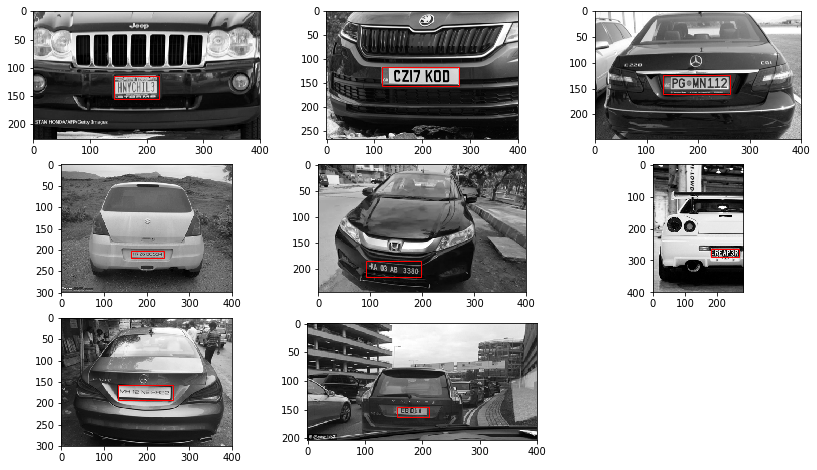

In [240]:
def LoadImage(fname): #on doit avoir des images nuances de gris
    image = cv2.imread(fname)
    img_gray = rgb2gray(image)
    img_gray = img_gray/255
    return img_gray

def LoadAnnotation_xml(fname) :
    tree = etree.parse(fname)
    for dim in tree.xpath("size"):
        width = int(dim.xpath("width")[0].text)
        height = int(dim.xpath("height")[0].text)
    for dim in tree.xpath("object/bndbox"):
        left_top_x = int(int(dim.xpath("xmin")[0].text))
        left_top_y = int(int(dim.xpath("ymin")[0].text))
        right_bottom_x = int(int(dim.xpath("xmax")[0].text))
        right_bottom_y = int(int(dim.xpath("ymax")[0].text))    
    return [left_top_x, left_top_y, right_bottom_x, right_bottom_y]

def LoadData_xml(paths) : 
    xs = []
    ys = []
    for ex_paths in paths:
        img_path = ex_paths[0]
        ann_path = ex_paths[1]
        xs.append(LoadImage(img_path))
        ys.append(LoadAnnotation_xml(ann_path))
    
    return np.array(xs), np.array(ys)

X_train_kaggle, Y_train_kaggle = LoadData_xml(tr_paths_kaggle)

def show_image(image, labels):
    rect = Rectangle((labels[0], labels[1]), labels[2]-labels[0], labels[3]-labels[1], edgecolor='r', fill=False)
    plt.imshow(image)
    gca = plt.gca()
    gca.add_patch(rect)
    
def plot_images(images, labels, nb_images):
    rcParams['figure.figsize'] = 14, 8
    plt.gray()
    fig = plt.figure()
    for i in range(min(nb_images, images.shape[0])):
        fig.add_subplot(3, 3, i+1)
        show_image(images[i], labels[i])
    plt.show()    


nb_images = 8
xs = [random.randint(0, X_train_kaggle.shape[0]-1) for _ in range(nb_images)]

plot_images(X_train_kaggle[xs], Y_train_kaggle[xs], nb_images) 
 


#Récupération des train set et test set

In [241]:
debug = False 

In [242]:
def LoadImage(path): #on doit avoir des images nuances de gris
    if debug : print("loading image "+str(path))
    image = cv2.imread(path)
    img_gray = rgb2gray(image)
    image_input = img_gray/255
    return image_input

def resize_image(image_input, width=128, height=64):
  image_output = np.array(Image.fromarray(image_input).resize((width, height)))
  if debug : print("resize image "+str(image_input.shape) + " to "+str(image_output.shape))
  return image_output

def load_and_resize(path):
  image_input = LoadImage(path)
  image_output = resize_image(image_input)
  return image_output

In [243]:
def LoadAnnotation_json(fname) :
    with open(fname) as data_file:    
        data = json.load(data_file)

    left_top_x = data["objects"][0]["points"]["exterior"][0][0]
    left_top_y = data["objects"][0]["points"]["exterior"][0][1]
    right_bottom_x = data["objects"][0]["points"]["exterior"][2][0]
    right_bottom_y = data["objects"][0]["points"]["exterior"][2][1]
    # on retourne 2 points du rectangle
    return [left_top_x, left_top_y, right_bottom_x, right_bottom_y]

def resize(original, final, to_resize):
  resized = to_resize * final / original
  if debug : 
    print("original: ", original)
    print("original: ", final)
    print("original: ", to_resize)
    print("original: ", resized)
  return resized

def LoadAnnotation_xml(path) :
    width_output = 128
    height_output = 64
    tree = etree.parse(path)
    for dim in tree.xpath("size"):
        width = int(dim.xpath("width")[0].text)
        height = int(dim.xpath("height")[0].text)

    for dim in tree.xpath("object/bndbox"):
        left_top_x_original = int(dim.xpath("xmin")[0].text)
        if debug : print("left_top_x_original: ", left_top_x_original)
        left_top_x_final = resize(width, width_output, left_top_x_original)
        if debug : print("left_top_x_final: ", left_top_x_final)

        left_top_y_original = int(dim.xpath("ymin")[0].text)
        if debug : print("left_top_y_original: ", left_top_x_original)
        left_top_y_final = resize(height, height_output, left_top_y_original)
        if debug : print("left_top_y_final: ", left_top_x_original)

        right_bottom_x_original = int(dim.xpath("xmax")[0].text)
        if debug : print("right_bottom_x_original: ", right_bottom_x_original)
        right_bottom_x_final = resize(width, width_output, right_bottom_x_original)

        right_bottom_y_original = int(dim.xpath("ymax")[0].text)
        if debug : print("right_bottom_y_original: ", right_bottom_y_original)
        right_bottom_y_final = resize(height, height_output, right_bottom_y_original)
    return [left_top_x_final, left_top_y_final, right_bottom_x_final, right_bottom_y_final]

In [244]:
def LoadData_json(paths):
    xs = []
    ys = []
    for ex_paths in paths:
        img_path = ex_paths[0]
        ann_path = ex_paths[1]
        xs.append(load_and_resize(img_path))
        ys.append(LoadAnnotation_json(ann_path))
    
    return np.array(xs), np.array(ys)

def LoadData_xml(paths) : 
    xs = []
    ys = []
    for ex_paths in paths:
        img_path = ex_paths[0]
        ann_path = ex_paths[1]
        xs.append(load_and_resize(img_path))
        ys.append(LoadAnnotation_xml(ann_path))
    
    return np.array(xs), np.array(ys)

In [245]:
X_train_kaggle, Y_train_kaggle = LoadData_xml(tr_paths_kaggle)
print("Train_kaggle done")
X_train_origin, Y_train_origin = LoadData_json(tr_paths_origin)
print("Train_origin done")
X_train = np.concatenate((X_train_kaggle, X_train_origin), axis = 0)
Y_train = np.concatenate((Y_train_kaggle, Y_train_origin), axis = 0)
print("Train done")
X_test_origin, Y_test_origin = LoadData_json(te_paths_origin)
print("Test_origin done")
X_test_kaggle, Y_test_kaggle = LoadData_xml(te_paths_kaggle)
print("Test_kaggle done")

X_test = np.concatenate((X_test_kaggle, X_test_origin), axis = 0)
Y_test = np.concatenate((Y_test_kaggle, Y_test_origin), axis = 0)
print("Test done")

print("check shapes:")
print("X_train - ", X_train.shape)
print("Y_train - ", Y_train.shape)
print("X_test - ", X_test.shape)
print("Y_test - ", Y_test.shape)


Train_kaggle done
Train_origin done
Train done
Test_origin done
Test_kaggle done
Test done
check shapes:
('X_train - ', (1133, 64, 128))
('Y_train - ', (1133, 4))
('X_test - ', (122, 64, 128))
('Y_test - ', (122, 4))


### Show sample images

<Figure size 1008x576 with 0 Axes>

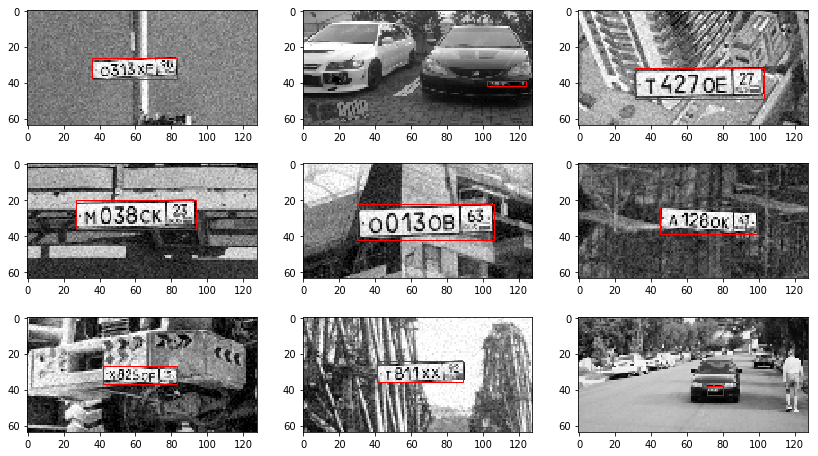

In [247]:
def show_image(image, labels):
    rect = Rectangle((labels[0], labels[1]), labels[2]-labels[0], labels[3]-labels[1], edgecolor='r', fill=False)
    plt.imshow(image)
    gca = plt.gca()
    gca.add_patch(rect)
    
def plot_images(images, labels, nb_images):
    rcParams['figure.figsize'] = 14, 8
    plt.gray()
    fig = plt.figure()
    for i in range(min(nb_images, images.shape[0])):
        fig.add_subplot(3, 3, i+1)
        show_image(images[i], labels[i])
    plt.show()    
    
#plot_images(X_train[0], Y_train[0], nb_images) 

nb_images = 9
xs = [random.randint(0, X_train.shape[0]-1) for _ in range(nb_images)]

plot_images(X_train[xs], Y_train[xs], nb_images) 
               
 

## Build Tensorflow neural net

In [ ]:
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, LeakyReLU
from keras.models import Sequential
from keras.optimizers import adam

X_train = X_train.reshape(-1, 64, 128, 1)
X_test = X_test.reshape(-1, 64, 128, 1)

print("check shapes:")
print("X_train - ", X_train.shape)
print("Y_train - ", Y_train.shape)
print("X_test - ", X_test.shape)
print("Y_test - ", Y_test.shape)


model = Sequential()

model.add(Conv2D(32, (3, 3), activation = 'relu', input_shape=(64, 128, 1))) #taille des images (64,128,1)
model.add(MaxPooling2D((3, 3)))
model.add(Conv2D(64, (2, 2), activation = 'relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (2, 2), activation ='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Flatten())
model.add(Dense(500, activation='relu'))
model.add(Dense(500, activation='relu'))
model.add(Dense(4))

model.summary()

opt = adam(lr=0.001, decay=1e-6)

model.compile(loss='mean_squared_error', optimizer=opt)


model.fit(X_train, Y_train, batch_size=20, epochs=50, validation_data=(X_test, Y_test))

In [ ]:
image_to_predict = load_and_resize('/content/drive/MyDrive/EISTI/3A/Data_to_train/kaggle/test/img/Cars2.png')
print("shape originale : ", image_to_predict.shape)
image_to_predict = image_to_predict.reshape(-1, 64, 128, 1)
print("shape avant predict doit etre (x, 64, 128, 1) : ", image_to_predict.shape)
result = model.predict(image_to_predict)

image_to_predict = image_to_predict.reshape(-1, 1, 64, 128)
results = np.array([result.flatten()])
print("X input_display, doit etre (1, 64, 128) : ", image_to_predict.shape)
print("Y input_display, doit etre (1,4) : ", results.shape)
plot_images(image_to_predict[0], results, 1)


**texte en gras**### Train old

In [ ]:
X2_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1]*X_train.shape[2]))
Y2_train = Y_train / (64.0, 32.0, 64.0, 32.0) - 1.0

X2_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1]*X_test.shape[2]))
Y2_test = Y_test / (64.0, 32.0, 64.0, 32.0) - 1

dataset = Dataset(X2_train, Y2_train)

In [ ]:
g = tf.Graph()
with g.as_default():
    session = tf.Session()
    
    model = build_model()
    loss = mse(model.y_placeholder, model.output)
    
    saver = tf.train.Saver()
    start_time = time.time()
    best_score = 1

    train_step = tf.train.AdamOptimizer().minimize(loss)

    session = tf.InteractiveSession()
    session.run(tf.global_variables_initializer())
    #saver.restore(session, os.path.join(MODEL_PATH, "model"))

    last_epoch = -1
    while dataset.epoch_completed() < EPOCH:
        (batch_x, batch_y) = dataset.next_batch(20)
        train_step.run(feed_dict={model.x_placeholder: batch_x, model.y_placeholder: batch_y})
        if dataset.epoch_completed() > last_epoch:
            last_epoch = dataset.epoch_completed()
            score_test = loss.eval(feed_dict={model.x_placeholder: X2_test, model.y_placeholder: Y2_test})
            if score_test < best_score:
                best_score = score_test
                saver.save(session, os.path.join(MODEL_PATH, "model"))
            if dataset.epoch_completed() % 1 == 0:
                epm = 60 * dataset.epoch_completed() / (time.time()-start_time)
                print('Epoch: %d, Score: %f, Epoch per minute: %f' % (dataset.epoch_completed(), score_test, epm))
    print('Finished in %f seconds.' % (time.time()-start_time)) 
    
    session.close()

### Show test set predictions

In [ ]:
g = tf.Graph()
with g.as_default():
    session = tf.InteractiveSession()
    model = build_model()
    saver = tf.train.Saver()
    saver.restore(session, os.path.join(MODEL_PATH, "model"))
    ids = [random.randint(0, X2_test.shape[0]-1) for _ in range(9)]
    predictions = model.output.eval(session=session, feed_dict={model.x_placeholder: X2_test[ids]})
    plot_images(X_test[ids], (predictions+1) * (64, 32, 64, 32))
    session.close()

### Show train set predictions

In [ ]:
g = tf.Graph()
with g.as_default():
    session = tf.InteractiveSession()
    model = build_model()
    saver = tf.train.Saver()
    saver.restore(session, os.path.join(MODEL_PATH, "model"))
    
    ids = [random.randint(0, X_train.shape[0]-1) for _ in range(9)]
    predictions = model.output.eval(session=session, feed_dict={model.x_placeholder: X2_train[ids]})
    plot_images(X_train[ids], (predictions+1) * (64, 32, 64, 32))

    session.close()

In [ ]:
def mse(expected, predicted):
    se = tf.square(expected - predicted)
    return tf.reduce_mean(se)

In [ ]:
def weight_variable(name, shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.get_variable(name, initializer=initial)

def bias_variable(name, shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.get_variable(name, initializer=initial)

def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')    

In [ ]:
tf.compat.v1.disable_eager_execution()
PIXEL_COUNT = X_train.shape[1] * X_train.shape[2]
print("Pixek : ", PIXEL_COUNT)
print(X_train.shape[1], X_train.shape[2])
print(64*128)
x_placeholder = tf.placeholder(tf.float32, shape=[None, PIXEL_COUNT])
print(x_placeholder)

x_image = tf.reshape(x_placeholder, [-1, 64, 128, 1])
print(x_image)
print(x_image.shape)

In [ ]:
PIXEL_COUNT = X_train.shape[1] * X_train.shape[2]
LABEL_COUNT = Y_train.shape[1]
# Create placeholders for image data and expected point positions

class Model(object):
    xxx = 0
    
# Build neural network
def build_model():
    x_placeholder = tf.placeholder(tf.float32, shape=[None, PIXEL_COUNT]) 
    y_placeholder = tf.placeholder(tf.float32, shape=[None, LABEL_COUNT])

    x_image = tf.reshape(x_placeholder, [-1, 64, 128, 1])
    # Convolution Layer 1
    W_conv1 = weight_variable("w1", [3, 3, 1, 32])
    b_conv1 = bias_variable("b1", [32])
    h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
    h_pool1 = max_pool_2x2(h_conv1)
    # Convolution Layer 2
    W_conv2 = weight_variable("w2", [2, 2, 32, 64])
    b_conv2 = bias_variable("b2", [64])
    h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
    h_pool2 = max_pool_2x2(h_conv2)
    # Convolution Layer 3
    W_conv3 = weight_variable("w3", [2, 2, 64, 128])
    b_conv3 = bias_variable("b3", [128])
    h_conv3 = tf.nn.relu(conv2d(h_pool2, W_conv3) + b_conv3)
    h_pool3 = max_pool_2x2(h_conv3)
    # Dense layer 1
    h_pool3_flat = tf.reshape(h_pool3, [-1, 8*16*128])
    W_fc1 = weight_variable("w4", [8*16*128, 500])
    b_fc1 = bias_variable("b4", [500])
    h_fc1 = tf.nn.relu(tf.matmul(h_pool3_flat, W_fc1) + b_fc1)   
    # Dense layer 2
    W_fc2 = weight_variable("w5", [500, 500])
    b_fc2 = bias_variable("b5", [500])
    h_fc2 = tf.nn.relu(tf.matmul(h_fc1, W_fc2) + b_fc2)  
    # Output layer
    W_out = weight_variable("w6", [500, LABEL_COUNT])
    b_out = bias_variable("b6", [LABEL_COUNT])
    
    output = tf.matmul(h_fc2, W_out) + b_out
    
    model = Model()
    model.x_placeholder = x_placeholder
    model.y_placeholder = y_placeholder
    model.output = output

    return model

In [ ]:
class Dataset:

    def __init__(self, X, Y):
        self.X = X
        self.Y = Y
        self._epochs_completed = 0
        self._index_in_epoch = 0
        self._num_examples = X.shape[0]

    def next_batch(self, batch_size=20):
        start = self._index_in_epoch
        self._index_in_epoch += batch_size
        if self._index_in_epoch > self._num_examples:
            self._epochs_completed += 1
            # Shuffle the data
            perm = np.arange(self._num_examples)
            np.random.shuffle(perm)
            self.X = self.X[perm]
            self.Y = self.Y[perm]
            # Start next epoch
            start = 0
            self._index_in_epoch = batch_size
            assert batch_size <= self._num_examples
        end = self._index_in_epoch
        return self.X[start:end], self.Y[start:end]

    def epoch_completed(self):
        return self._epochs_completed